In [1]:
import pandas as pd
from itertools import combinations
import openai
import base64
import numpy as np
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
human_data = pd.read_csv("data\\30_rocks_similarities.csv", index_col=0)

In [3]:
human_data

,I_Andesite_06,I_Basalt_02,I_Diorite_10,I_Gabbro_03,I_Granite_11,I_Obsidian_09,I_Pegmatite_01,I_Peridotite_11,I_Pumice_06,I_Rhyolite_11,...,S_Bituminous Coal_10,S_Breccia_11,S_Chert_03,S_Conglomerate_08,S_Dolomite_12,S_Micrite_09,S_Rock Gypsum_02,S_Rock Salt_12,S_Sandstone_12,S_Shale_04
I_Andesite_06,NaN,5.5294,6.7059,6.8824,5.6324,3.7206,3.2500,5.1765,3.1912,5.5441,...,4.0294,4.2059,2.7941,3.4118,4.1912,2.8676,3.3676,5.0000,2.4118,4.7206
I_Basalt_02,5.5294,NaN,3.7353,5.8382,2.9559,5.3676,2.8382,3.9706,3.1765,6.5441,...,5.7353,2.6765,3.1324,2.6029,5.7500,6.1618,4.6765,3.8824,3.2941,6.7353
I_Diorite_10,6.7059,3.7353,NaN,6.8382,6.5735,3.1176,4.4559,5.3529,3.8529,3.5735,...,3.7206,3.2353,3.2353,4.5000,4.6176,3.7353,3.2647,3.7500,2.6471,3.7059
I_Gabbro_03,6.8824,5.8382,6.8382,NaN,6.0882,3.8971,4.0294,4.7206,3.3971,4.0735,...,4.9559,4.0588,2.8382,3.3676,4.1324,3.6176,3.7794,3.2206,2.2794,5.0294
I_Granite_11,5.6324,2.9559,6.5735,6.0882,NaN,2.5147,4.7059,3.6618,3.5000,3.4706,...,3.2353,4.3235,3.0000,3.9853,4.1618,3.1618,4.3676,4.3235,2.5882,2.7500
I_Obsidian_09,3.7206,5.3676,3.1176,3.8971,2.5147,NaN,3.2059,3.2059,2.3676,3.9265,...,7.0588,2.3235,4.1912,2.9559,3.2059,4.4118,4.0441,3.7794,2.4706,5.6029
I_Pegmatite_01,3.2500,2.8382,4.4559,4.0294,4.7059,3.2059,NaN,5.7059,3.8382,2.7059,...,3.2353,2.8971,4.2941,5.8676,2.7941,3.5000,2.9118,3.3971,2.7059,2.7059
I_Peridotite_11,5.1765,3.9706,5.3529,4.7206,3.6618,3.2059,5.7059,NaN,5.5735,3.1765,...,3.4265,2.1765,3.3382,6.1471,3.3676,4.1618,2.7647,2.5294,2.9559,3.2941
I_Pumice_06,3.1912,3.1765,3.8529,3.3971,3.5000,2.3676,3.8382,5.5735,NaN,3.8382,...,2.9706,2.1029,4.3088,4.5441,4.3382,4.2500,2.9706,2.1324,5.5147,2.3382
I_Rhyolite_11,5.5441,6.5441,3.5735,4.0735,3.4706,3.9265,2.7059,3.1765,3.8382,NaN,...,4.8382,2.3235,3.8529,2.9559,6.9853,4.4559,4.9853,3.7794,3.9118,5.5294


In [4]:
client = openai.OpenAI(
  organization='org-LewILTfUI8Y9pb57686FCqdy',
  project='proj_fPgG23M7oU6YDmEKQRAc5H7y',
)

In [5]:
# Function to encode the image
def encode_image(image):
  image_path = f"data\\360 Rocks\\{image}.jpg"
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')  


In [6]:
SYSTEM_PROMPT = (
    "You are assisting in a study in which you are shown pairs of rocks and "
    "rate how visually similar they are on a scale from 1 to 9, with 1 being most dissimilar, "
    "5 being moderately similar, and 9 being most similar. "
    "You are shown examples of highly similar, moderately similar, and highly dissimilar pairs. "
    "You use these examples to anchor your judgments. "
    "You use the full range of the scale and only respond with a 1 or 2 when the pair is extremely dissimilar. "
    "You only respond with a single number from 1 to 9, without explaining your reasoning."
    )

SIMILAR_EXAMPLE_PROMPT = (
    "This is an example of a highly similar pair of rocks."
)

DISSIMILAR_EXAMPLE_PROMPT = (
    "This is an example of a highly dissimilar pair of rocks."
)

MEDIUM_EXAMPLE_PROMPT = (
    "This is an example of a moderately similar pair of rocks."
)

QUESTION_PROMPT = (
    "From 1-9, how visually similar are these two rocks?"
)

SIMILAR_ROCK1 = "I_Obsidian_09"
SIMILAR_ROCK2 = "M_Anthracite_12"

DISSIMILAR_ROCK1 = "S_Rock Salt_12"
DISSIMILAR_ROCK2 = "S_Sandstone_12"

MEDIUM_ROCK1 = "I_Andesite_06"
MEDIUM_ROCK2 = "I_Peridotite_11"

SEED = 123

In [7]:
def create_messages(prompt, rocks):
    messages = {"role": "user",
       "content": [{"type": "text", "text": prompt}] + [
         {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{encode_image(rock)}"
            },
          }
        for rock in rocks]
    }
    return messages

In [8]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(10))
def completion_with_backoff(**kwargs):
    return client.chat.completions.create(**kwargs)

In [9]:
def get_responses(rock1, rock2): 
  response = completion_with_backoff(
    model="gpt-4o",
    messages=[
      {"role": "system", "content": SYSTEM_PROMPT},
      create_messages(SIMILAR_EXAMPLE_PROMPT, (SIMILAR_ROCK1, SIMILAR_ROCK2)),
      create_messages(MEDIUM_EXAMPLE_PROMPT, (MEDIUM_ROCK1, MEDIUM_ROCK2)),
      create_messages(DISSIMILAR_EXAMPLE_PROMPT, (DISSIMILAR_ROCK1, DISSIMILAR_ROCK2)),
      create_messages(QUESTION_PROMPT, (rock1, rock2)),
    ],
    logprobs=True,
    top_logprobs=20,
    seed=SEED,
    max_tokens=1,
  )
  return response

In [10]:
def get_average_rating(logprobs):
    word2num = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9}
    ratings = np.array([i+1 for i in range(9)])
    weights = np.array([0.]*9)
    for lp in logprobs:
        token = lp.token.strip().lower()
        i = word2num.get(token, token)
        try:
            i = int(i) - 1
            weights[i] += np.exp(lp.logprob)
        except:
            continue
    try:
        av = np.average(ratings, weights=weights)
    except:
        av = 0.0
    return av


In [11]:
results = []
pairs = [comb for comb in combinations(human_data.columns, 2)]
for pair in pairs:
    rock1, rock2 = pair

    human = human_data[rock1][rock2]

    response = get_responses(rock1, rock2)
    logprobs = response.choices[0].logprobs.content[0].top_logprobs
    chatgpt = get_average_rating(logprobs)

    results.append({"Rock1": rock1, "Rock2": rock2, "Human Rating": human, "ChatGPT Rating": chatgpt, "Response": response})


In [12]:
results = pd.DataFrame(results)
results.to_csv("chatgpt_similarities.csv", index=False)

In [13]:
results

,Rock1,Rock2,Human Rating,ChatGPT Rating,Response
0,I_Andesite_06,I_Basalt_02,5.5294,5.410093,ChatCompletion(id='chatcmpl-9UL8zfwHKVjE5ebF9O...
1,I_Andesite_06,I_Diorite_10,6.7059,7.463376,ChatCompletion(id='chatcmpl-9UL95Bg5bc8Mp5hdaZ...
2,I_Andesite_06,I_Gabbro_03,6.8824,7.926699,ChatCompletion(id='chatcmpl-9UL9IbRfPQ6JtOsl0q...
3,I_Andesite_06,I_Granite_11,5.6324,5.896600,ChatCompletion(id='chatcmpl-9UL9QoKCypO0ACu915...
4,I_Andesite_06,I_Obsidian_09,3.7206,2.048678,ChatCompletion(id='chatcmpl-9UL9WQLaMTrNUGxtDc...
...,...,...,...,...,...
430,S_Rock Gypsum_02,S_Sandstone_12,2.5294,1.895034,ChatCompletion(id='chatcmpl-9ULyNrj3hTItwCxGzf...
431,S_Rock Gypsum_02,S_Shale_04,3.1029,1.968626,ChatCompletion(id='chatcmpl-9ULyW0NvmejOeF2nx3...
432,S_Rock Salt_12,S_Sandstone_12,1.8676,1.033163,ChatCompletion(id='chatcmpl-9ULygUerSEhZQ3p6Yt...
433,S_Rock Salt_12,S_Shale_04,2.9412,1.995280,ChatCompletion(id='chatcmpl-9ULymDucFo9kWMuFOV...


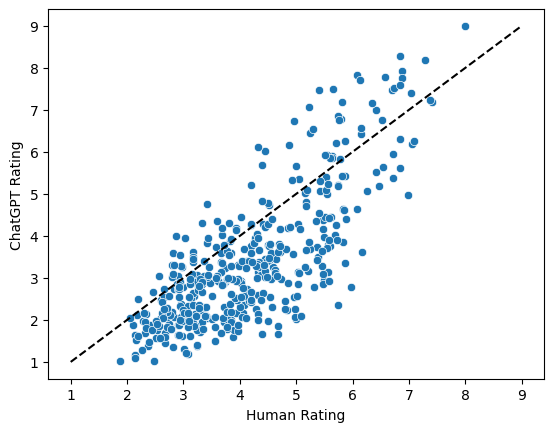

In [14]:
sns.scatterplot(results, x="Human Rating", y="ChatGPT Rating")
plt.plot([1, 9], [1, 9], 'k--')

In [15]:
results.corr(numeric_only=True)

,Human Rating,ChatGPT Rating
Human Rating,1.000000,0.781791
ChatGPT Rating,0.781791,1.000000
